In [32]:
#
# BTC_JPY, FX_BTC_JPY, BCH_JPY, ETH_JPY, BTC_JPY+BCH_JPY合計 のチャートを折れ線グラフで描く
#
%matplotlib inline
import datetime
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.finance as mf
from matplotlib.dates import date2num

In [33]:
import yaml
f = open('default.yaml', 'r+')
config = yaml.load(f)
f.close()
mongo_url = 'mongodb://' + config['mongo_user'] + ':' + config['mongo_pwd'] + '@' + config['mongo_host'] + ':' + config['mongo_port'] + '/' + config['mongo_db']

In [34]:
client = pymongo.MongoClient(mongo_url)
db = client.bitflyer
btc_jpy = db.lightning_executions_BTC_JPY_OHLC_86400
fx_btc_jpy = db.lightning_executions_FX_BTC_JPY_OHLC_86400
eth_btc = db.lightning_executions_ETH_BTC_OHLC_86400
bch_btc = db.lightning_executions_BCH_BTC_OHLC_86400
#btc_jpy = db.lightning_executions_BTC_JPY_OHLC_300
#fx_btc_jpy = db.lightning_executions_FX_BTC_JPY_OHLC_300
#eth_btc = db.lightning_executions_ETH_BTC_OHLC_300
#bch_btc = db.lightning_executions_BCH_BTC_OHLC_300

In [35]:
btc_jpy_date=[]
btc_jpy_price = []
btc_jpy_volume = []

#直近のデータ400件
count = 400

skip = 0
if (btc_jpy.count() > count):
    skip = btc_jpy.count() - count

for data in btc_jpy.find().skip(skip).sort('id',1):
    btc_jpy_date.append(data['op_date'])
    btc_jpy_price.append(data['cl'])
    btc_jpy_volume.append(data['vol_sell'] + data['vol_buy'])

def getBTCPrice(date):
    price = 0
    for i in range(0, len(btc_jpy_date)):
        if btc_jpy_date[i] <= date:
            price = btc_jpy_price[i]
        else:
            break
    return price

In [36]:
fx_btc_jpy_date=[]
fx_btc_jpy_price = []
fx_btc_jpy_volume = []
fx_btc_jpy_ratio = []

skip = 0
if (fx_btc_jpy.count() > count):
    skip = fx_btc_jpy.count() - count

i = 0
for data in fx_btc_jpy.find().skip(skip).sort('id',1):
    fx_btc_jpy_date.append(data['op_date'])
    fx_btc_jpy_price.append(data['cl'])
    fx_btc_jpy_volume.append(data['vol_sell'] + data['vol_buy'])
    fx_btc_jpy_ratio.append(float(data['cl'])/btc_jpy_price[i])
    i += 1;


In [37]:
eth_jpy_date=[]
eth_jpy_price = []
eth_jpy_volume = []

skip = 0
if (eth_btc.count() > count):
    skip = eth_btc.count() - count

for data in eth_btc.find().skip(skip).sort('id',1):
    if (btc_jpy_date[0] > data['op_date']):
        continue
    eth_jpy_date.append(data['op_date'])
    # ETH_JPY = ETH_BTC * BTC_JPY
    eth_jpy_price.append(data['cl'] * getBTCPrice(data['op_date']))
    eth_jpy_volume.append(data['vol_sell'] + data['vol_buy'])

In [38]:
bch_jpy_date=[]
bch_jpy_price = []
bch_jpy_volume = []
total_price = []

skip = 0
if (bch_btc.count() > count):
    skip = bch_btc.count() - count

for data in bch_btc.find().skip(skip).sort('id',1):
    if (btc_jpy_date[0] > data['op_date']):
        continue
    bch_jpy_date.append(data['op_date'])
    # BCH_JPY = BCH_BTC * BTC_JPY
    bch_jpy_price.append(data['cl'] * getBTCPrice(data['op_date']))
    bch_jpy_volume.append(data['vol_sell'] + data['vol_buy'])
    total_price.append((data['cl'] + 1.0) * getBTCPrice(data['op_date']))


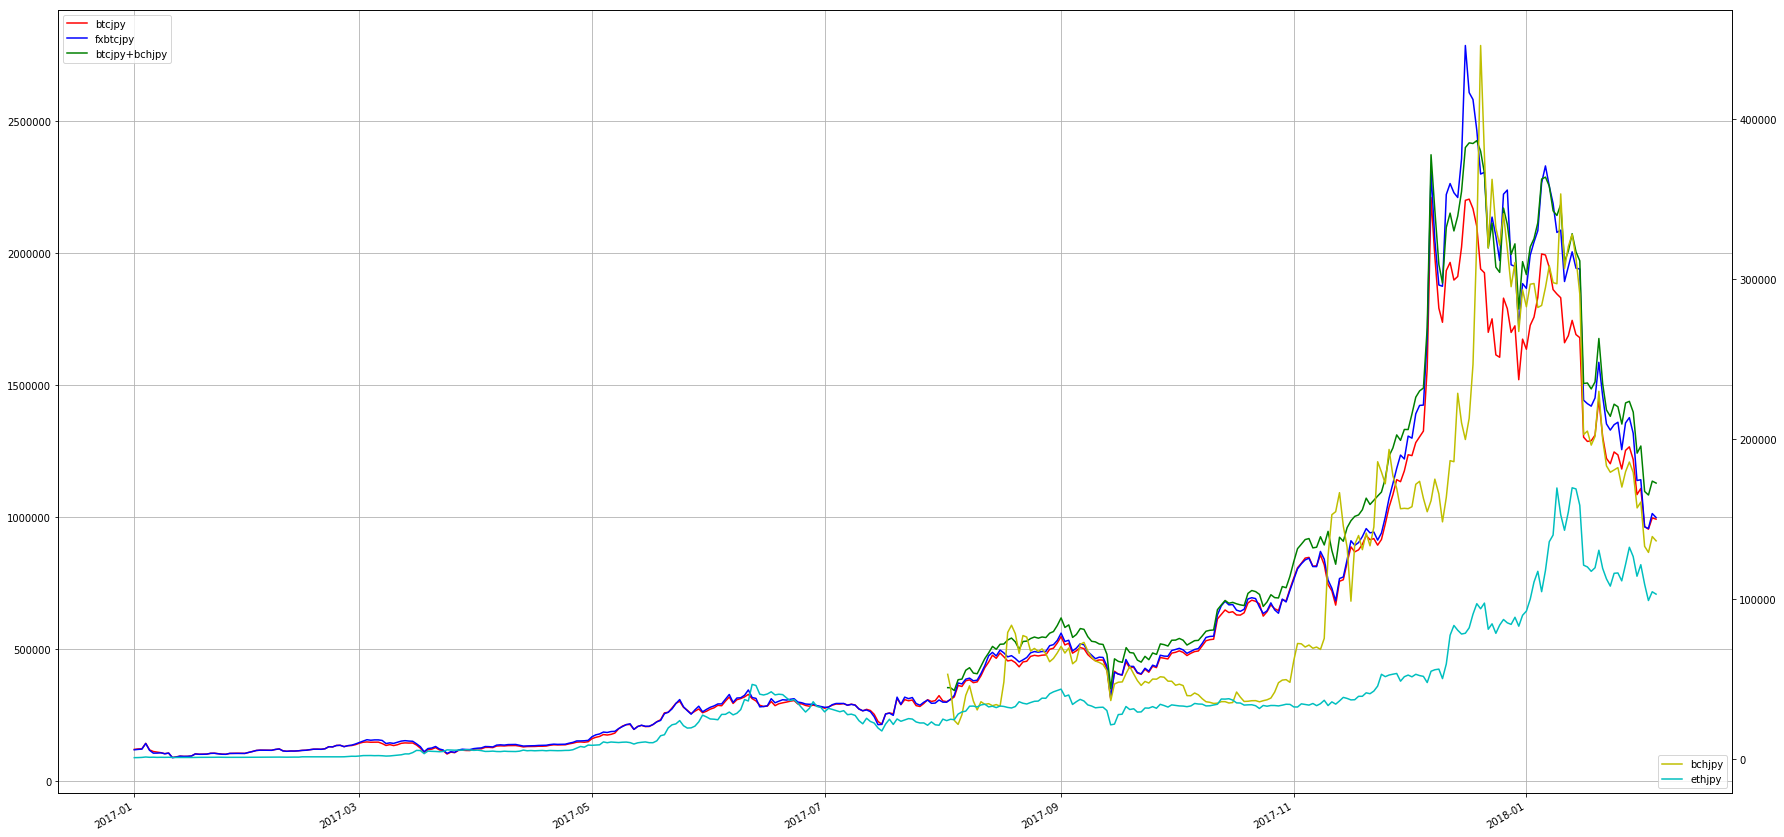

In [39]:
# BTC_JPY (赤)
# FX_BTC_JPY (青)
# BTC_JPY + BCH_JPY (緑)
# BCH_JPY (黄)
# ETH_JPY (シアン)
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(btc_jpy_date, btc_jpy_price, color='r', label='btcjpy')
ax.plot(fx_btc_jpy_date, fx_btc_jpy_price, color='b', label='fxbtcjpy')
ax.plot(bch_jpy_date, total_price, color='g', label='btcjpy+bchjpy')
ax2 = ax.twinx()
ax2.plot(bch_jpy_date, bch_jpy_price, color='y', label='bchjpy')
ax2.plot(eth_jpy_date, eth_jpy_price, color='c', label='ethjpy')
ax.legend(loc=2)
ax2.legend(loc=4)
fig.autofmt_xdate()

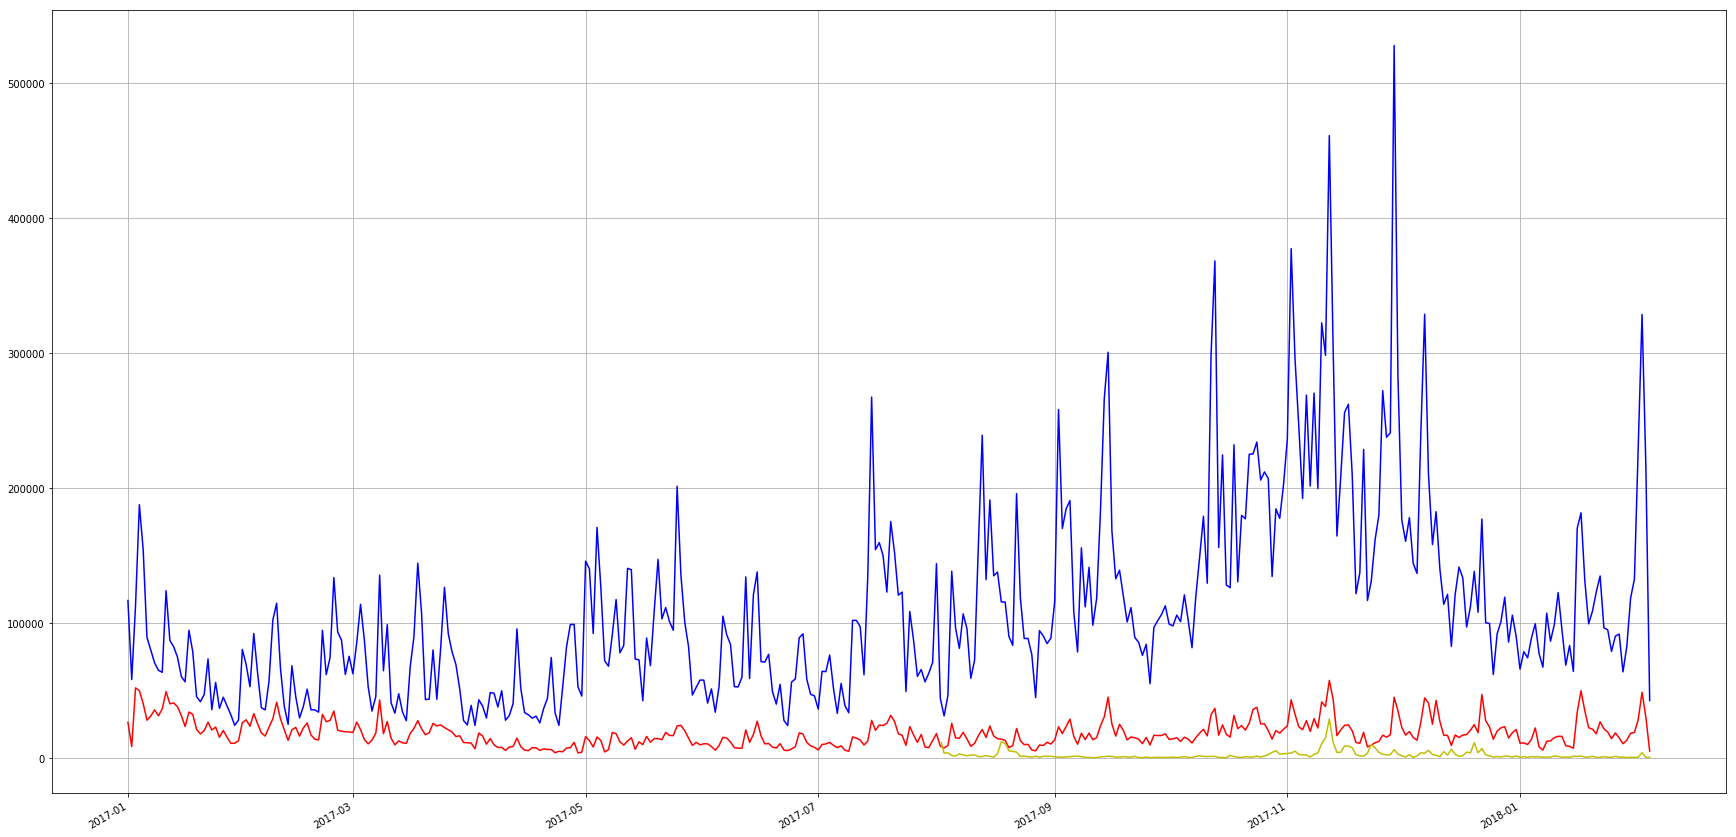

In [40]:
# 出来高
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(btc_jpy_date, btc_jpy_volume, color='r')
ax.plot(fx_btc_jpy_date, fx_btc_jpy_volume, color='b')
ax.plot(bch_jpy_date, bch_jpy_volume, color='y')
fig.autofmt_xdate()

In [41]:
# 最終取引価格
print 'BTC/JPY:', btc_jpy_price[-1]
print 'FX-BTC/JPY:', fx_btc_jpy_price[-1]
print 'FX/BTC Ratio:', fx_btc_jpy_ratio[-1]
print 'ETH/JPY:', eth_jpy_price[-1]
print 'BCH/JPY:', bch_jpy_price[-1]

BTC/JPY: 992250
FX-BTC/JPY: 998485
FX/BTC Ratio: 1.00628369866
ETH/JPY: 103174.155
BCH/JPY: 136474.065


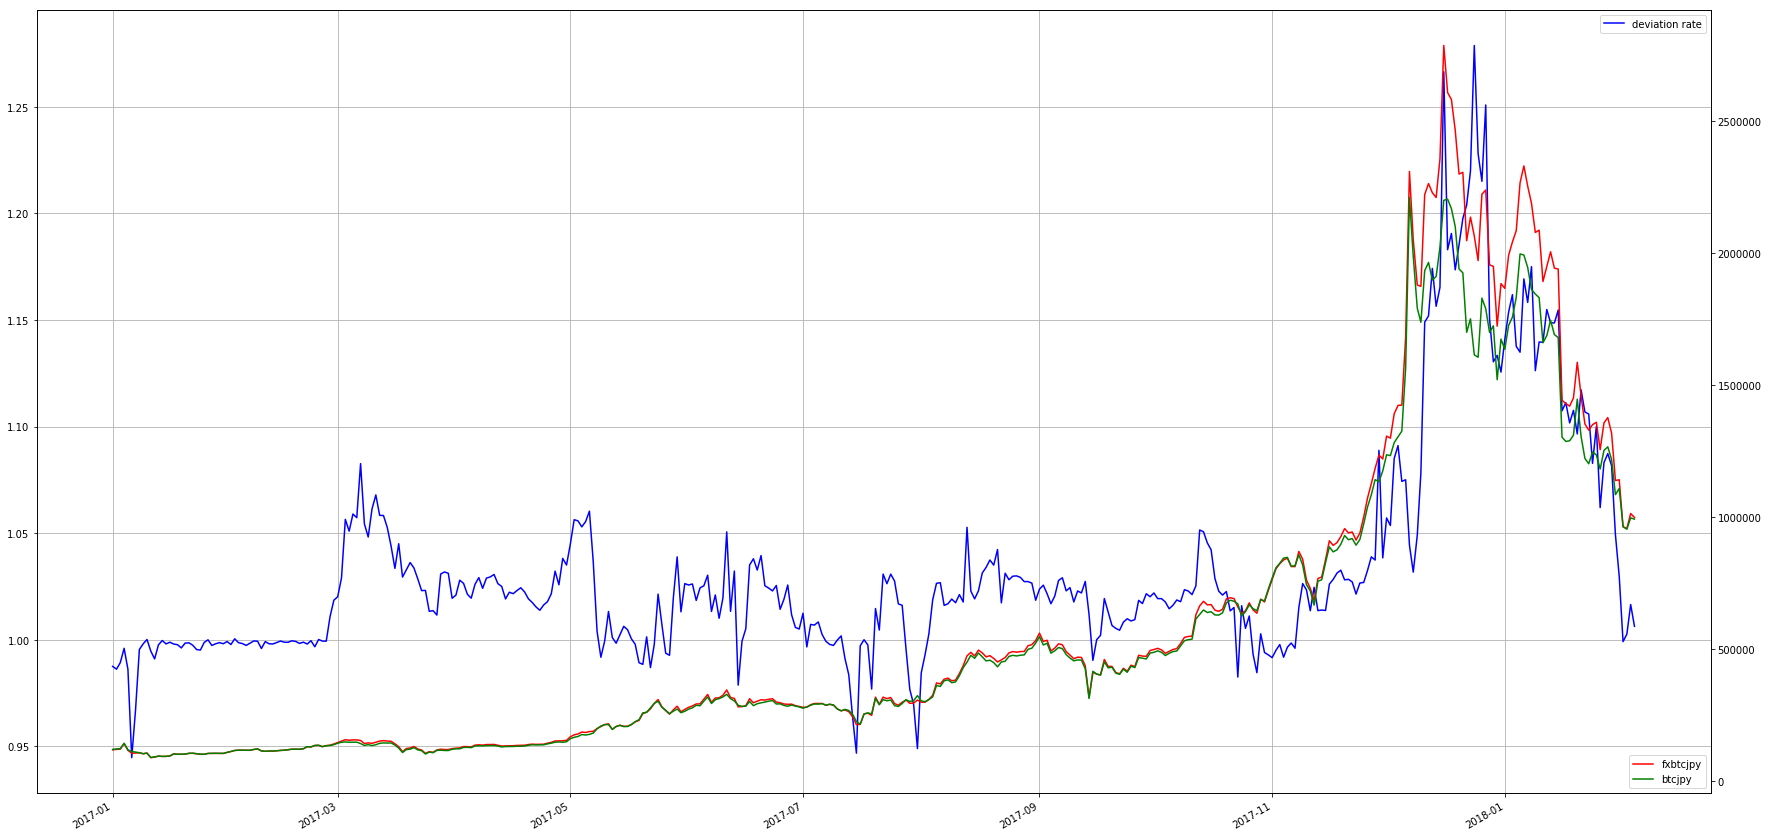

In [42]:
# FX_BTC_JPY価格 (赤)
# BTC_JPY価格 (緑)
# FX_BTC, BTC現物の乖離率 (青)
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(fx_btc_jpy_date, fx_btc_jpy_ratio, color='b', label='deviation rate')
ax.legend(loc=1)
ax2 = ax.twinx()
ax2.plot(fx_btc_jpy_date, fx_btc_jpy_price, color='r', label='fxbtcjpy')
ax2.plot(btc_jpy_date, btc_jpy_price, color='g', label='btcjpy')
ax2.legend(loc=4)
fig.autofmt_xdate()